In [1]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf

In [3]:
# Importation of data
list_tickers = ["META", "NFLX", "TSLA"]
database = yf.download(list_tickers)

# Take only the adjusted stock price
data = database["Adj Close"]

data

[*********************100%***********************]  3 of 3 completed


,META,NFLX,TSLA
Date,,,
2002-05-23,NaN,1.196429,NaN
2002-05-24,NaN,1.210000,NaN
2002-05-28,NaN,1.157143,NaN
2002-05-29,NaN,1.103571,NaN
2002-05-30,NaN,1.071429,NaN
...,...,...,...
2022-12-12,114.709999,315.179993,167.820007
2022-12-13,120.150002,320.339996,160.949997
2022-12-14,121.589996,317.829987,156.800003


In [4]:
# We do a loop to create the SMAs for each asset
for col in list_tickers:
    data[f"pct {col}"] = data[col].pct_change(1)
    data[f"SMA3 {col}"] = data[col].rolling(3).mean().shift(1)
    data[f"SMA12 {col}"] = data[col].rolling(12).mean().shift(1)
    data[f"Momentum factor {col}"] = data[f"SMA3 {col}"] - data[f"SMA12 {col}"]

# Normalizing the zscore
split = int(0.7*len(data))
train_set = data.iloc[:split,:]
test_set = data.iloc[split:,:]

# Find the mean and std vectors
columns = [f"Momentum factor {col}" for col in list_tickers]
train_set_mean = train_set[columns].mean()
train_set_std = train_set[columns].std()

# Create the zscores
train_set[columns] = (train_set[columns] - train_set_mean) / train_set_std
test_set[columns] = (test_set[columns] - train_set_mean) / train_set_std

# Find the medians
median = train_set[columns].median()

In [5]:
median

Momentum factor META   -0.079964
Momentum factor NFLX   -0.057579
Momentum factor TSLA   -0.030504
dtype: float64

In [6]:
# Compute the signals and the profits
for i in range(len(columns)):

    # Initialize a new column for the signal
    test_set[f"signal {columns[i]}"] = 0

    # Signal is -1 if factor < median
    test_set.loc[test_set[f"{columns[i]}"]<median[i], 
               f"signal {columns[i]}"] = -1

    # Signal is 1 if factor > median
    test_set.loc[test_set[f"{columns[i]}"]>median[i], 
               f"signal {columns[i]}"] = 1


    # Compute the profit
    test_set[f"profit {columns[i]}"] = (test_set[f"signal {columns[i]}"]\
          .shift(1)) * test_set[f"pct {list_tickers[i]}"]

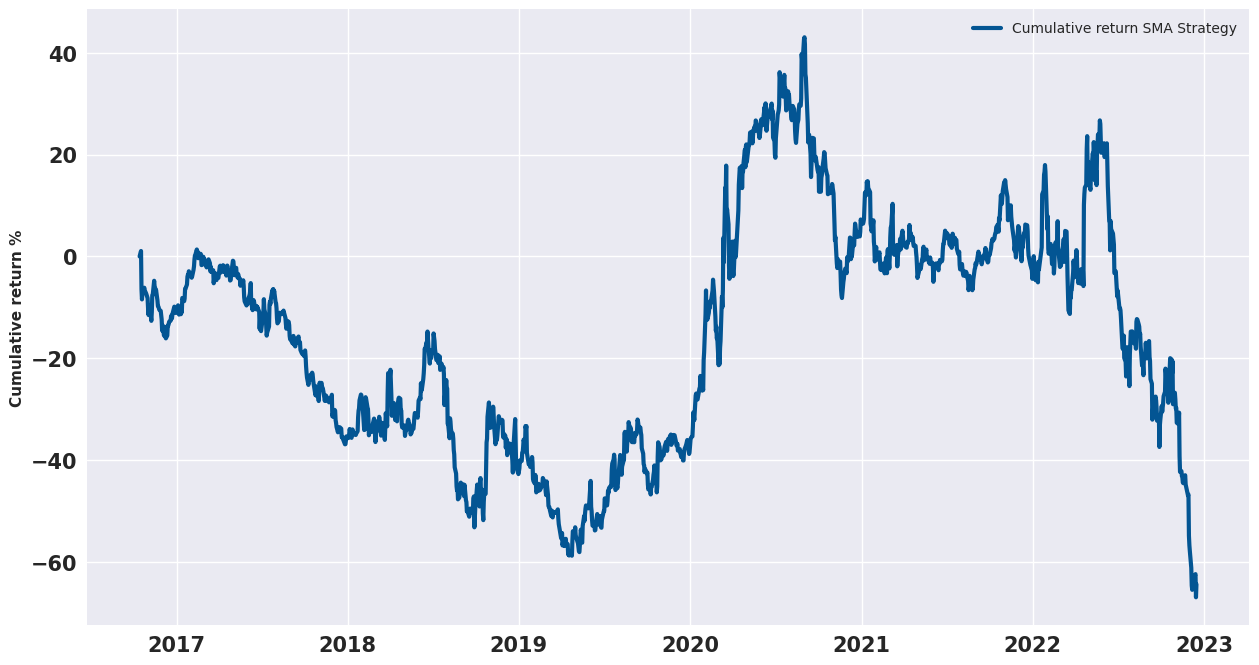

In [11]:
returns = test_set[[f"profit {columns[i]}" \
        for i in range(len(columns))]].sum(axis=1) .cumsum()*100/3

plt.figure(figsize=(15,8))
plt.plot(returns, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.legend(["Cumulative return SMA Strategy"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")

plt.show()